In [0]:
# Install Kaggle API
#!pip install -q kaggle

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "*********"
os.environ['KAGGLE_KEY'] = "************

# download data from Kaggle
!kaggle competitions download -c facial-keypoints-detection -p data

training.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
SampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
IdLookupTable.csv: Skipping, found more recently modified local copy (use --force to force download)


In [4]:

# Unzip training and test datasets to data directory
!unzip data/training.zip -d data
!unzip data/test.zip -d data

Archive:  data/training.zip
replace data/training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/training.csv       
Archive:  data/test.zip
replace data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/test.csv           


## Import Pakages

In [0]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [0]:
data_dir = Path('./data')
train = pd.read_csv(data_dir / 'training.csv')

In [7]:
train.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,65.2302,66.7376,66.5747,65.2706,66.6072,68.4913,66.6769,66.8504,67.8395,69.2335,65.5956,64.7625,66.0827,64.7186,66.3343,64.553,65.3184,65.4594,65.3769,72.3532,64.1556,64.9563,69.4418,67.5089,65.3781,66.0595,64.7125,66.215,67.0397,64.3325,...,66.6593,65.2627,66.3166,67.9037,66.4645,66.301,67.1193,64.8367,65.3903,62.3849,65.6084,61.9972,64.9061,67.0451,60.2021,72.2262,67.7241,63.0133,67.2779,65.84,69.4632,64.3929,67.3677,68.3209,66.162,66.6519,70.5049,71.2582,69.6162,64.6155,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,34.3426,39.8864,37.308,34.9402,38.9381,35.9002,33.9412,35.637,38.5979,40.0215,36.6264,34.9334,37.1537,35.8612,33.7213,36.5242,35.2704,38.9086,38.1289,34.4171,35.2538,35.2355,37.8516,35.7277,35.632,36.8486,34.2681,35.6378,32.372,34.6073,...,40.0731,36.2124,43.8757,41.7278,37.9797,35.7512,37.9044,35.2976,32.2801,32.2983,37.6214,37.2758,41.8102,41.7374,37.7435,40.0464,38.876,36.0536,37.3832,39.1238,41.0387,38.2252,38.0488,36.8326,35.9309,37.3327,35.7834,39.7446,38.0495,35.1653,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,28.8027,30.2704,30.4453,33.0227,28.5962,27.8312,30.7136,32.5281,28.0167,25.5508,31.5408,31.8597,27.9783,31.5907,29.0771,32.2198,30.3096,32.0514,29.2155,28.6554,30.7579,29.1167,28.6935,30.6683,30.191,26.5891,30.8571,30.4626,27.1397,32.8899,...,31.0751,29.3557,28.1583,34.0728,30.0619,30.8998,33.7967,31.2624,28.2914,32.7659,31.2643,31.4254,30.5803,29.8587,38.6491,33.0462,29.3992,28.7469,29.1766,29.494,33.8927,29.21,28.6823,29.1977,33.1005,29.2966,32.1823,33.4652,29.494,26.7072,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,33.9378,38.8144,37.308,32.9769,36.3032,37.0221,36.1495,36.5246,36.3977,38.0719,39.3078,37.1915,37.436,39.1194,34.0977,38.0786,38.7026,39.2602,39.5589,32.828,35.2538,35.2355,35.6967,33.6292,34.3974,37.7069,32.2253,37.5031,32.372,37.2519,...,35.5442,42.2983,37.3487,38.4538,39.0829,36.8461,38.2101,40.0939,36.1694,40.8549,38.459,37.9127,36.566,38.177,37.4441,37.8698,37.9297,38.0497,40.6963,42.3241,41.8064,38.6517,37.8144,37.5662,34.9929,37.8341,39.0827,36.6878,42.5967,39.8279,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,58.7538,61.0176,59.0362,60.5032,61.7145,62.3222,60.3671,61.2288,60.1393,60.2627,59.1474,59.9242,59.8731,59.2879,59.9368,58.4007,60.1705,59.8324,58.4306,63.8785,57.2384,59.201,62.585,61.2136,59.5131,60.0528,58.8754,59.9972,60.3898,59.6305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406,35.5571,39.8864,38.2768,34.9402,38.9381,36.1807,35.2031,36.5246,39.698,40.0215,37.9068,35.9011,38.2828,37.762,34.8497,37.5387,36.2995,39.6119,39.3545,34.9467,36.1483,36.5438,38.2435,36.8932,36.558,37.7069,34.8519,36.5704,33.2301,35.4888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.51

In [0]:
print('size of traning data {}'.format(len(train)))
print('Missing vlaue col ')
print(train.isnull().any().value_counts())
train.isnull().sum().sort_values(ascending=False)

## Fill the missing values 

In [0]:
train.fillna(method='ffill',inplace=True)

In [19]:
image_list=[]
for i in train['Image']:
    i=i.split(' ')
    image_list.append(i)
len(image_list)

7049

In [0]:
image_list=[]

## Plotting the Images

In [0]:
def show_keypoints(image, keypoints):
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [0]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

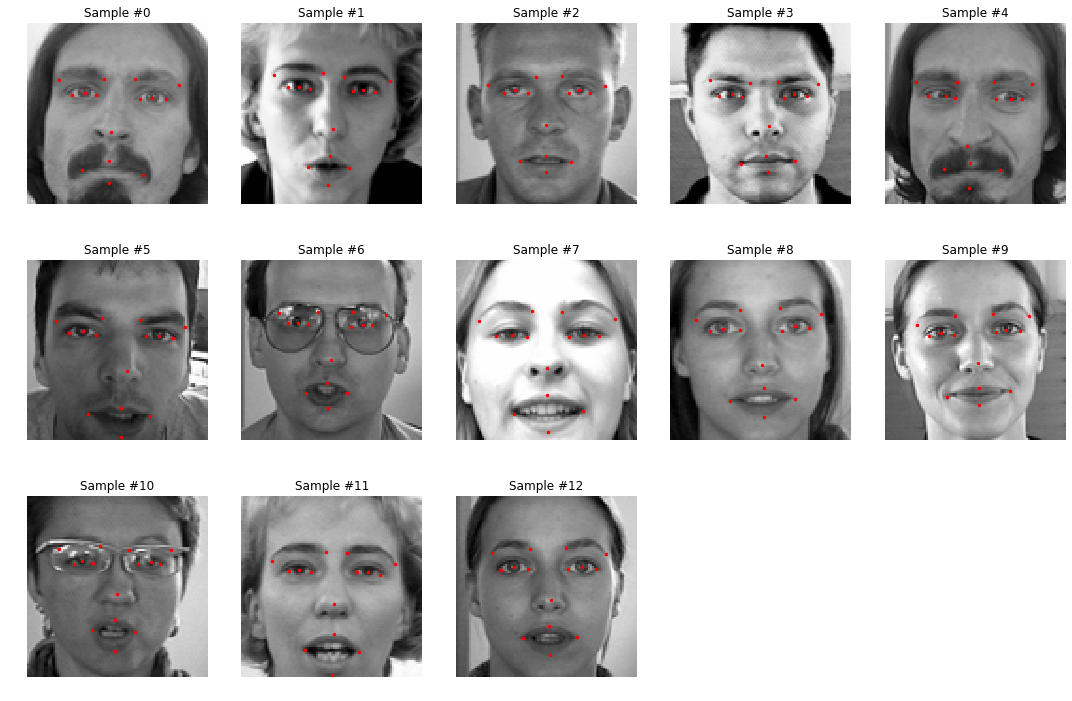

In [23]:
show_images(train, range(0,13))

In [0]:
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
        
    def __len__(self):
      return len(self.dataframe)
        
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
    
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
    
        sample = {'image': image, 'keypoints': keypoints}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

In [0]:
class Normalize(object):
    '''Normalize input images'''
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [78]:
test_data = pd.read_csv(data_dir / 'test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 27.9+ KB


In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

## Preparing the data and conveting it to pytorch tensors

In [0]:
def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [0]:
# drop any-missing-keypoint records
train_df = train.dropna()
test_df = test_data

# how many samples per batch to load
batch_size = 128
# percentage of training set to use as                                                                                                                
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([Normalize(), ToTensor()])

# Load the training data and test data
trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)
# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [0]:
from torch import nn, optim
import torch.nn.functional as F

## Naive Multilayer Preceptron model

96*96 ==> 128 ==> 64==>30
Regularization : Dropout

In [0]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        
        '''
        Buid a forward network with arbitrary hidden layers.
        
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        
        super(MLP, self).__init__()
        
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, 
            hidden_layers=[128, 64], drop_p=0.1)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Loss function ==> Mean Squared Error                      

Optimizer ==> ADAM


In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [0]:
def Train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses

In [89]:
train_losses, valid_losses = Train(train_loader, valid_loader, model,
                                   criterion, optimizer, n_epochs=50, 
                                   saved_model='model.pt')

Epoch: 1 	Training Loss: 23.096903 	Validation Loss: 11.839338
Validation loss decreased (inf --> 11.839338).  Saving model ...
Epoch: 2 	Training Loss: 13.778232 	Validation Loss: 10.961334
Validation loss decreased (11.839338 --> 10.961334).  Saving model ...
Epoch: 3 	Training Loss: 12.954022 	Validation Loss: 10.829545
Validation loss decreased (10.961334 --> 10.829545).  Saving model ...
Epoch: 4 	Training Loss: 12.245903 	Validation Loss: 10.480733
Validation loss decreased (10.829545 --> 10.480733).  Saving model ...
Epoch: 5 	Training Loss: 11.981116 	Validation Loss: 10.015399
Validation loss decreased (10.480733 --> 10.015399).  Saving model ...
Epoch: 6 	Training Loss: 11.318853 	Validation Loss: 9.706860
Validation loss decreased (10.015399 --> 9.706860).  Saving model ...
Epoch: 7 	Training Loss: 11.319070 	Validation Loss: 9.939237
Epoch: 8 	Training Loss: 11.104928 	Validation Loss: 10.098420
Epoch: 9 	Training Loss: 11.139407 	Validation Loss: 10.062923
Epoch: 10 	Train

In [0]:
# Function to plot RMSE vs epochs
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

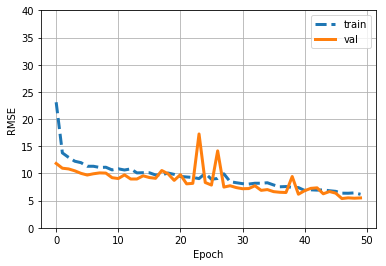

In [91]:
plot_RMSE(train_losses, valid_losses, y_max=40)

In [0]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [0]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

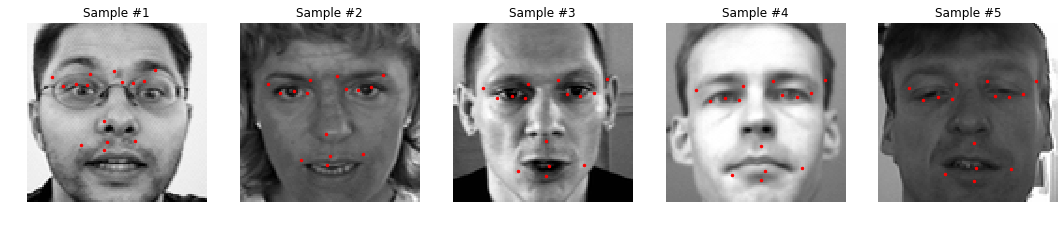

In [94]:
model.load_state_dict(torch.load('model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)


In [0]:

def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

In [0]:
create_submission(predictions)

In [97]:
!kaggle competitions submit -c facial-keypoints-detection -f data/submission.csv -m "Base MLP"


100% 629k/629k [00:11<00:00, 57.9kB/s]
Successfully submitted to Facial Keypoints Detection

## Data Augmentation : Vertical , Horizontal , Sideways Flips 

In [0]:
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}


In [0]:
aug_train_df = train.dropna()
aug_transform = transforms.Compose([RandomHorizontalFlip(p=1.0), 
                                    Normalize(),
                                    ToTensor()])
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_transform)

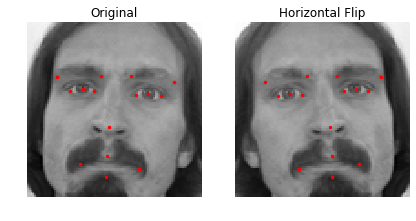

In [100]:
plt.subplot(1,2,1)
plt.title(f'Original')
plt.axis('off')
plt.tight_layout()
image = trainset[0]['image'].numpy().squeeze()
keypoints = trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)
plt.subplot(1,2,2)
plt.title(f'Horizontal Flip')
plt.axis('off')
plt.tight_layout()
image = aug_trainset[0]['image'].numpy().squeeze()
keypoints = aug_trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)

In [0]:
def show_dataset_images(dataset, n_images=10, n_cols=5, figsize=(15,10)):
    '''
    Show Dataset images with keypoints in grids
    Args:
        dataset (Dataset): data
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if data consists of keypoint data
    '''
        
    plt.figure(figsize=figsize)
    n_rows = n_images // n_cols + 1
    for idx in range(n_images):
        image = dataset[idx]['image'].numpy().squeeze()
        keypoints = dataset[idx]['keypoints'].numpy().reshape(-1,2)
        plt.subplot(n_rows, n_cols, idx+1)
        plt.grid(False)
        plt.tight_layout()
        show_keypoints(image, keypoints)

In [0]:
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2


# Drop missing data
aug_train_df = train.dropna()

# Define a transform to augment the data
aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])

# Load the training data
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)


# prepare data loaders
aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

In [0]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, hidden_layers=[128, 64], drop_p=0.1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [110]:
aug_train_losses, aug_valid_losses = Train(aug_train_loader, aug_valid_loader, model, criterion,optimizer, n_epochs=50, saved_model='aug_model.pt')

Epoch: 1 	Training Loss: 22.860821 	Validation Loss: 13.272764
Validation loss decreased (inf --> 13.272764).  Saving model ...
Epoch: 2 	Training Loss: 13.705531 	Validation Loss: 11.981106
Validation loss decreased (13.272764 --> 11.981106).  Saving model ...
Epoch: 3 	Training Loss: 13.058255 	Validation Loss: 12.005417
Epoch: 4 	Training Loss: 12.324749 	Validation Loss: 12.773367
Epoch: 5 	Training Loss: 12.894655 	Validation Loss: 11.049114
Validation loss decreased (11.981106 --> 11.049114).  Saving model ...
Epoch: 6 	Training Loss: 11.871960 	Validation Loss: 10.938529
Validation loss decreased (11.049114 --> 10.938529).  Saving model ...
Epoch: 7 	Training Loss: 11.668058 	Validation Loss: 12.417581
Epoch: 8 	Training Loss: 11.975939 	Validation Loss: 12.125110
Epoch: 9 	Training Loss: 12.170037 	Validation Loss: 11.266348
Epoch: 10 	Training Loss: 11.634871 	Validation Loss: 11.849771
Epoch: 11 	Training Loss: 11.202652 	Validation Loss: 10.495876
Validation loss decreased (

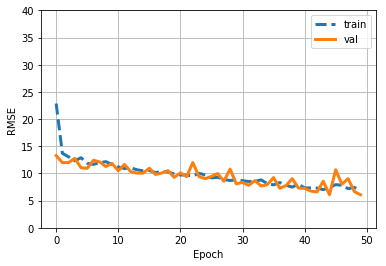

In [111]:
plot_RMSE(aug_train_losses, aug_valid_losses, y_max=40)

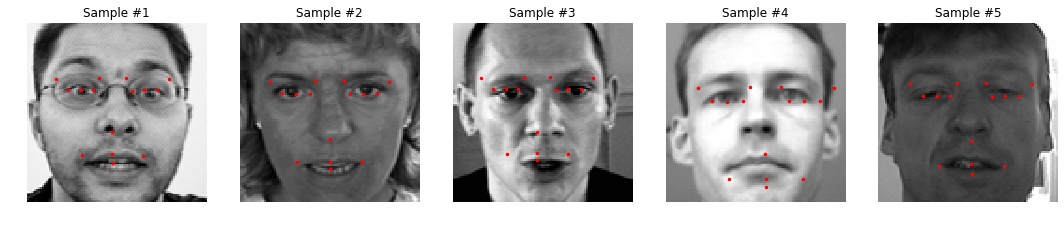

In [112]:
model.load_state_dict(torch.load('aug_model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

In [0]:
create_submission(predictions, 
                  pred_file='data/aug_mlp_preds.csv', 
                  sub_file='data/aug_mlp_submission.csv')

In [114]:
!kaggle competitions submit -c facial-keypoints-detection -f data/aug_mlp_submission.csv -m "Augmented MLP"

100% 628k/628k [00:09<00:00, 65.0kB/s]
Successfully submitted to Facial Keypoints Detection

## Using convolution NN

1 * 96 * 96  ==> 16 * 96 * 96 ==> 16 * 48 * 48 ===> 32 * 48 * 48 ===>32 * 24 * 2 4 ===>64 *  12 * 12   ==>64 * 12 * 12 ===>1024 ===> 30

In [0]:
 class CNN(nn.Module):
    '''
    Convolutional Neural Network model
            
    Args:
        ---------
        output_size (integer): size of the output layer
    '''
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
       
        x = self.pool(F.relu(self.conv1(x)))
        
        x = self.conv1_bn(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv2_bn(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        
        x = self.conv3_bn(x)
        
        x = x.view(-1, 64*12*12)
        
        x = F.relu(self.fc1(self.dropout(x)))
        
        x = self.fc2(self.dropout(x))
        
        return x

In [0]:
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [140]:
aug_cnn_train_losses, aug_cnn_valid_losses = Train(aug_train_loader, aug_valid_loader, model, criterion, 
                                                   optimizer, n_epochs=50, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 14.988577 	Validation Loss: 11.078042
Validation loss decreased (inf --> 11.078042).  Saving model ...
Epoch: 2 	Training Loss: 5.718863 	Validation Loss: 4.909840
Validation loss decreased (11.078042 --> 4.909840).  Saving model ...
Epoch: 3 	Training Loss: 5.286941 	Validation Loss: 5.099053
Epoch: 4 	Training Loss: 4.743743 	Validation Loss: 3.746171
Validation loss decreased (4.909840 --> 3.746171).  Saving model ...
Epoch: 5 	Training Loss: 4.465184 	Validation Loss: 3.760493
Epoch: 6 	Training Loss: 4.397987 	Validation Loss: 3.539737
Validation loss decreased (3.746171 --> 3.539737).  Saving model ...
Epoch: 7 	Training Loss: 4.267079 	Validation Loss: 3.439482
Validation loss decreased (3.539737 --> 3.439482).  Saving model ...
Epoch: 8 	Training Loss: 4.334687 	Validation Loss: 3.528425
Epoch: 9 	Training Loss: 4.273211 	Validation Loss: 3.929242
Epoch: 10 	Training Loss: 4.069159 	Validation Loss: 3.265545
Validation loss decreased (3.439482 --> 3.265

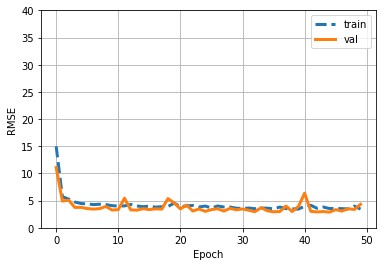

In [141]:
plot_RMSE(aug_cnn_train_losses, aug_cnn_valid_losses, y_max=40)


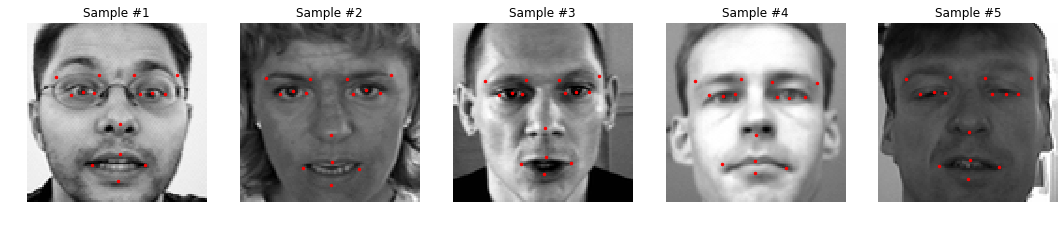

In [142]:
model.load_state_dict(torch.load('aug_cnn.pt'))

predictions = predict(test_loader, model)

create_submission(predictions, 
                  pred_file='data/aug_cnn_preds.csv', 
                  sub_file='data/aug_cnn_submission.csv')

view_pred_df(columns, test_df, predictions)

In [143]:
!kaggle competitions submit -c facial-keypoints-detection -f data/aug_cnn_submission.csv -m "Augmented CNN"

100% 629k/629k [00:09<00:00, 64.8kB/s]
Successfully submitted to Facial Keypoints Detection

In [124]:
IMG_SIZE

96